In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from os import path

In [2]:
def plot_I_vs_q(peak_list):
    qs = []
    Is = []
    
    for peak in peak_list:
        q = np.linalg.norm(peak.q().rowVector())
        I = peak.correctedIntensity().value()
        qs.append(q)
        Is.append(I)
    
    plt.figure(figsize=(10,10))
    plt.scatter(qs, Is)
    plt.show()
    
def plot_Isigma_vs_q(peak_list):
    qs = []
    Is = []
    
    for peak in peak_list:
        q = np.linalg.norm(peak.q().rowVector())
        inten = peak.correctedIntensity()
        
        Isigma = inten.value() / inten.sigma() if inten.sigma() > 0 else 0
        
        qs.append(q)
        Is.append(Isigma)
    
    plt.figure(figsize=(10,10))
    plt.scatter(qs, Is)
    plt.show()
    
def plot_dq_vs_frame(peak_list):
    dqs = []
    frames = []
    
    for i in range(len(peak_list)):
        peak = peak_list[i]
        obs_q = peak.q().rowVector()
        uc = peak.activeUnitCell()
        bu = uc.reciprocalBasis()
        hkl = nsx.MillerIndex(peak.q(), uc)
        pred_q = hkl.rowVector().dot(bu)
        assert(pred_q.shape == obs_q.shape)
        dq = np.linalg.norm(pred_q-obs_q)
        
        dqs.append(dq)
        frames.append(peak.getShape().center()[2])
        
    plt.figure(figsize=(10,10))
    plt.scatter(frames, dqs)
    plt.show()
    
def plot_dx_vs_frame(peak_list, outlier=20):
    dxs = []
    dys = []
    dzs = []
    frames = []
    
    for i in range(len(peak_list)):
        peak = peak_list[i]
        obs_x = peak.getShape().center()
        uc = peak.activeUnitCell()
        bu = uc.reciprocalBasis()
        hkl = nsx.MillerIndex(peak.q(), uc).rowVector()
        pred_q = hkl.dot(bu)
        
        predictor = nsx.PeakPredictor(peak.data())
        ellipsoid = nsx.Ellipsoid(pred_q.transpose(), 100.0*np.identity(3)) 
        
        #hkls = nsx.MillerIndexList()
        #hkls.push_back()
  
        #print(hkl)
        hkls = nsx.MillerIndexList()
        hkls.push_back(nsx.MillerIndex(int(hkl[0,0]), int(hkl[0,1]), int(hkl[0,2])))
        preds = predictor.predictPeaks(hkls, uc.reciprocalBasis())
            
        if len(preds) != 1:
            peak.setSelected(False)
            continue
            
        dx = obs_x - preds[0].getShape().center()
        dx = dx.reshape(3)
        
        if (np.linalg.norm(dx) > outlier):
            peak.setSelected(False)
            continue
        
        dxs.append(dx[0])
        dys.append(dx[1])
        dzs.append(dx[2])
        frames.append(peak.getShape().center()[2])

        
    print("npred", len(dxs))
    plt.figure(figsize=(10,10))
    plt.scatter(frames, dxs)
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.scatter(frames, dys)
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.scatter(frames, dzs)
    plt.show()
    
def find_batch(peak, batches):
    z = peak.getShape().center()[2,0]
    
    for b in batches:
        if b.contains(z):
            return b
        
    return None
    
def reindex(peak_list, batches):          
    new_peaks = []
    
    for peak in peak_list:
        
        batch = find_batch(peak, batches)
        
        if batch is None:
            continue
        
        hkl = np.array([[0.,0.,0.]])
        uc = batch.cell()
        
        if nsx.MillerIndex(peak.q(), uc).indexed(0.2):
            peak.addUnitCell(uc, True)
            new_peaks.append(peak)
            
    return new_peaks

def compute_statistics(peak_list, group, friedel):
    merged = nsx.MergedData(group, friedel)
    for peak in peak_list:
        if peak.isSelected():
            merged.addPeak(peak)
            
    r = nsx.RFactor()
    cc = nsx.CC()
    
    r.calculate(merged)
    cc.calculate(merged)
    
    stats = {}
    stats['CChalf'] = cc.CChalf()
    stats['CCtrue'] = cc.CCstar()
    stats['Rmeas'] = r.Rmeas()
    stats['Rmerge'] = r.Rmerge()
    stats['Rpim'] = r.Rpim()
    
    return stats

def num_selected_peaks(peaks):
    num_selected = 0
    
    for peak in peaks:
        if peak.isSelected():
            num_selected += 1
            
    return num_selected
    
def filter_peaks(peaks):
    for peak in peaks:
        if not peak.isSelected():
            continue
            
        if peak.pValue() > 1e-3:
            peak.setSelected(False)
            continue
            
        d = 1.0 / np.linalg.norm(peak.q())
        
        if d > 50.0 or d < 2.1:
            peak.setSelected(False)
            continue
            
        profile = nsx.Profile()
        
        if profile.fit(peak.getIntegration().getProjectionPeak()) == False:
            peak.setSelected(False)
            continue
        
def remove_deselected(data):
    peaks = data.getPeaks()
    
    for peak in peaks:
        if not peak.isSelected():
            data.removePeak(peak)

In [3]:
expt = nsx.Experiment('test', 'BioDiff2500')
diff = expt.getDiffractometer()
filename = path.expanduser("~/data/biodiff/p11202.hdf")
reader = nsx.HDF5DataReader(filename, diff)
data = nsx.DataSet(reader, diff)
expt.addData(data)

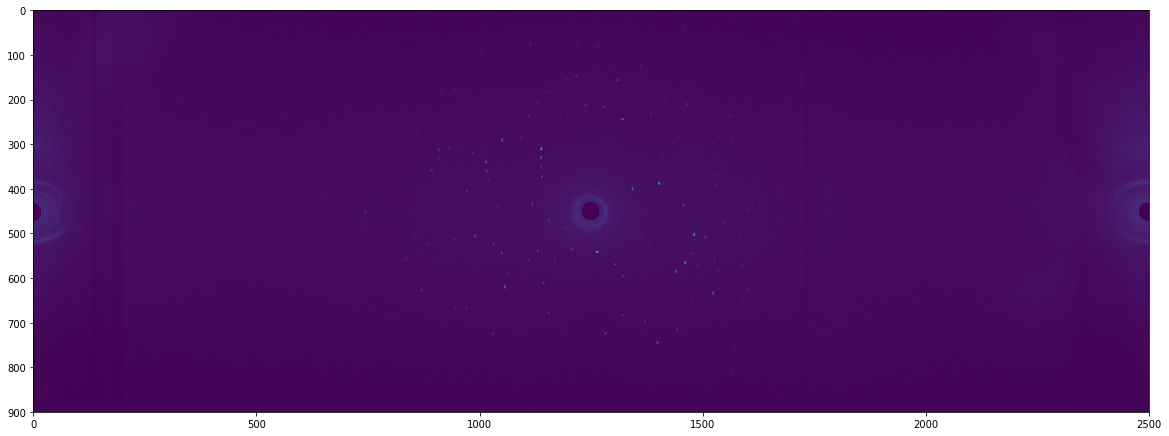

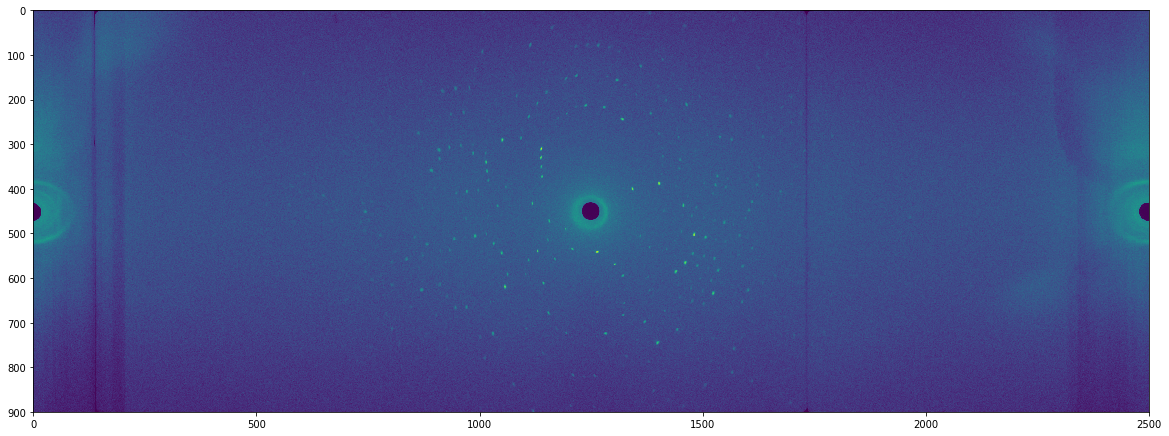

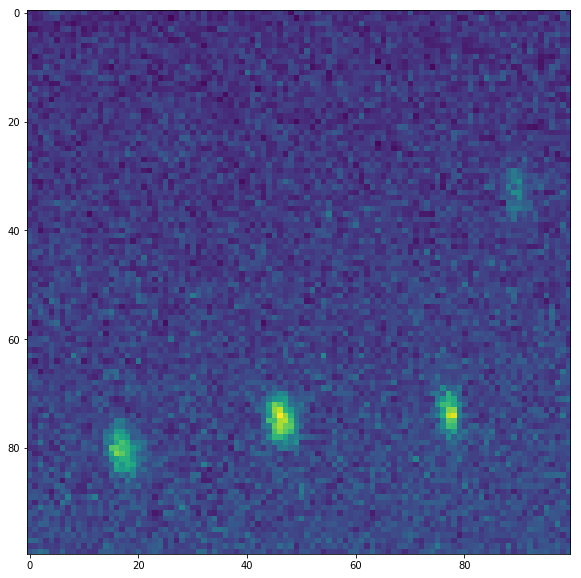

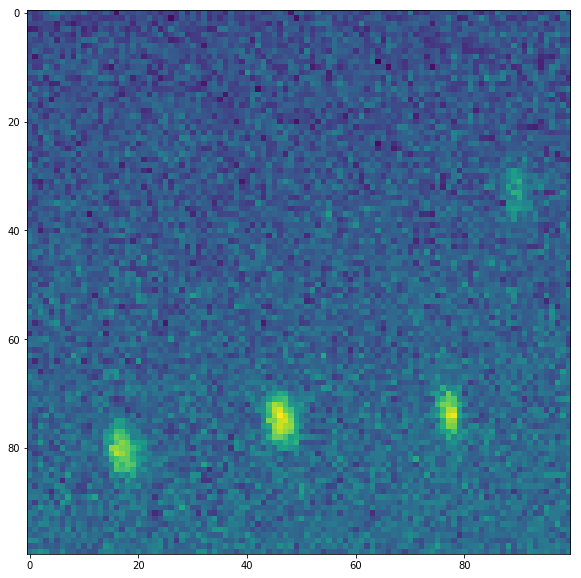

In [4]:
image = data.frame(0)

plt.figure(figsize=(20,10))
plt.imshow(image)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(np.log(image))
plt.show()


plt.figure(figsize=(20,10))
plt.imshow(image[100:200, 900:1000])
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(np.log(image[100:200, 900:1000]))
plt.show()

In [5]:
kernel = nsx.AnnularKernel(data.nRows(), data.nCols())
convolver = nsx.Convolver()
convolver.setKernel(kernel.matrix())

In [6]:
finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setIntegrationConfidence(0.98)
finder.setSearchConfidence(0.67)
finder.setThresholdType(1)
finder.setThresholdValue(80.0)
finder.setKernel(kernel)

In [7]:
peaks = finder.find([data])
print(len(peaks))

9203


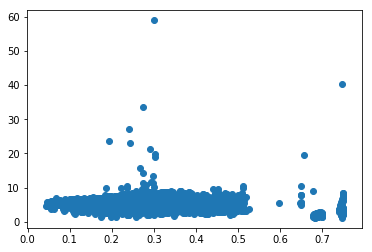

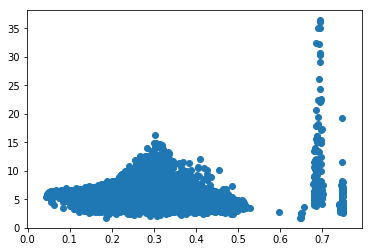

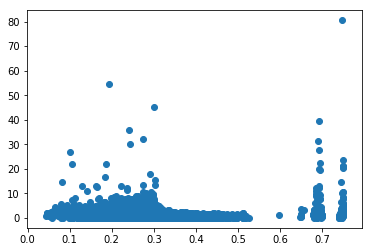

In [8]:
xs = []
ys = []
zs = []
qs = []

for peak in peaks:
    bb = peak.getShape().aabb()
    dd = bb.upper()-bb.lower()
    q = np.linalg.norm(peak.q().rowVector())
    xs.append(dd[0,0])
    ys.append(dd[1,0])
    zs.append(dd[2,0])
    qs.append(q)
    
plt.scatter(qs, xs)
plt.show()

plt.scatter(qs, ys)
plt.show()

plt.scatter(qs, zs)
plt.show()

In [11]:
#data.integratePeaks(peaks, 3, 4, 5, nsx.ProgressHandler())

In [9]:
for peak in peaks:
    peak.setSelected(True)

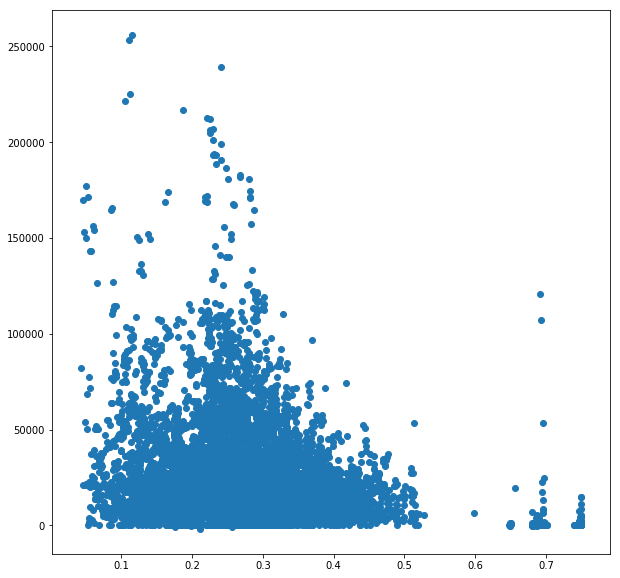

In [10]:
plot_I_vs_q(peaks)

8750


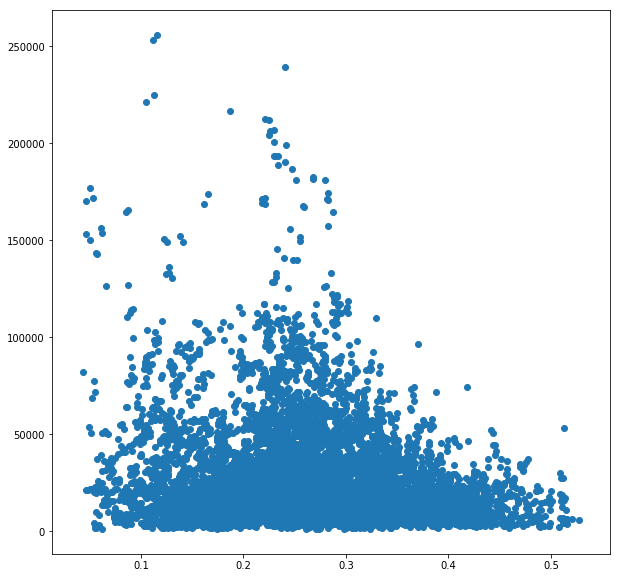

In [11]:
# clean up peaks
good_peaks = []

for peak in peaks:
    I = peak.correctedIntensity().value()
    
    # keep only selected peaks
    if not peak.isSelected():
        continue
    
    # keep only strong peaks for autoindex
    if I < 1000.0:
        continue
        
    d = 1.0 / np.linalg.norm(peak.q().rowVector())
    
    # keep peaks only in specified d range
    if d > 40.0 or d < 1.8:
        continue
        
    good_peaks.append(peak)
    
print(len(good_peaks))
plot_I_vs_q(good_peaks)

In [12]:
indexer = nsx.AutoIndexer(nsx.ProgressHandler())

for peak in good_peaks:
    indexer.addPeak(peak)

print("auto indexing", len(good_peaks), "peaks")
        
params = nsx.IndexerParameters()
handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

uc = nsx.UnitCell(soln[0])
sample = diff.sample()
sample.addUnitCell(uc)

indexed_peaks = []

for peak in good_peaks:
    hkl = nsx.MillerIndex(peak.q(), uc)
    if np.linalg.norm(hkl.error()) < 0.2:
        peak.addUnitCell(uc, True)
        indexed_peaks.append(peak)
    
ch = uc.character()
print("indexed", len(indexed_peaks), "of", len(good_peaks))
print("found unit cell with parameters: ")
print("a: ", ch.a)
print("b: ", ch.b)
print("c: ", ch.c)
print("alpha: ", ch.alpha)
print("beta: ", ch.beta)
print("gamma: ", ch.gamma)

auto indexing 8750 peaks
indexed 7434 of 8750
found unit cell with parameters: 
a:  54.66552559854839
b:  58.6006265743151
c:  66.69816170195563
alpha:  1.5707963267948966
beta:  1.5707963267948966
gamma:  1.5707963267948963


In [ ]:
plot_dq_vs_frame(indexed_peaks)
#plot_dx_vs_frame(indexed_peaks, 10)

In [13]:
def standard_coords(x, y, f, peak):
    q = peak.q()
    uc = peak.activeUnitCell()
    hkl = nsx.MillerIndex(q, uc)
    q0 = uc.fromIndex(1.0*hkl.rowVector())
    
    f0 = peak.getShape().center()[2,0]
    state0 = peak.data().interpolatedState(f0)
    state1 = peak.data().interpolatedState(f)

    q0 = q0.dot(state0.sampleOrientation())  
    ki = state.ki().rowVector()
    kf = q0 + ki
    
    e3 = ki + kf
    e1 = np.cross(kf, ki)
    e2 = np.cross(kf, e1)
    
    e1 = e1.reshape(3)
    e2 = e2.reshape(3)
    e3 = e3.reshape(3)
    
    e1 /= np.linalg.norm(e1)
    e2 /= np.linalg.norm(e2)
    e3 /= np.linalg.norm(e3)
    
    return np.array([e1, e2, e3]).transpose()

def standard_basis(peak):
    q = peak.q()
    uc = peak.activeUnitCell()
    hkl = nsx.MillerIndex(q, uc)
    q_pred = uc.fromIndex(1.0*hkl.rowVector())
    
    frame = peak.getShape().center()[2,0]
    state = peak.data().interpolatedState(frame)
    
    J = np.array([[0, -1, 0],[1, 0,0], [0,0,0]])
    
    ki = state.ki().rowVector()
    kf = q_pred + ki
    
    #e1 = np.cross(kf, ki)
    #e2 = np.cross(ki, e1)
    #print(J)
    e3 = q_pred.dot(J)
    #print("gggg")
    
    #print(e3)
    e3 = ki
    e1 = np.cross(kf, ki)
    e2 = np.cross(kf, e1)
    
    e1 = e1.reshape(3)
    e2 = e2.reshape(3)
    e3 = e3.reshape(3)
    
    e1 /= np.linalg.norm(e1)
    e2 /= np.linalg.norm(e2)
    e3 /= np.linalg.norm(e3)
    
    return np.array([e1, e2, e3]).transpose()

def standard_covariance(peak):
    B = standard_basis(peak)
    BI = np.linalg.inv(B)
    
    q = peak.q()
    uc = peak.activeUnitCell()
    hkl = nsx.MillerIndex(q, uc)
    q_pred = uc.fromIndex(1.0*hkl.rowVector())

    q_shape = peak.qShape()
    

    C = q_shape.inverseMetric()
    
    return BI.dot(C.dot(BI.transpose()))

#import random

mean_cov = np.zeros((3,3), dtype=np.float)
num = 0

for p in random.sample(indexed_peaks, 100):
    try:
        #c = standard_covariance(p)
        c = p.qShape().inverseMetric()
        mean_cov += c
        num += 1
        #w, _ = np.linalg.eig(mean_cov)
        #print(w)
    except:
        continue
        
mean_cov /= num

plt.imshow(mean_cov)
plt.show()

print(mean_cov / mean_cov.mean())

error = np.zeros((3,3), dtype=np.float)

num = 0

for p in indexed_peaks:
    try:        
        #c = standard_covariance(p)
        c = p.qShape().inverseMetric()
        error += (c-mean_cov)**2
        num += 1
        #w, _ = np.linalg.eig(mean_cov)
        #print(w)
    except:
        continue
        
error /= num*np.linalg.norm(mean_cov)**2

plt.imshow(error)
plt.show()

print(error)

print(error.sum())

NameError: name 'random' is not defined

In [289]:
from scipy.optimize import least_squares

def get_cov_rot(peaks):
    result = []

    for peak in peaks:
        try:
            shape = peak.qShape()
            cov = shape.inverseMetric()
            cov = 0.5*(cov + cov.transpose())
            z = peak.getShape().center()[2,0]
            rot = peak.data().interpolatedState(z).sampleOrientation()
            result.append((cov,rot))
        except:
            continue
            
    return result
    
fit_data = get_cov_rot(indexed_peaks)

N = len(fit_data)
C_M = np.zeros((3,3), dtype=np.float)
C_D = np.zeros((3,3), dtype=np.float)

for i in range(100):
        
    error = 0
    norm = 0
    
    dC_M = np.zeros((3,3), dtype=np.float)
    dC_D = np.zeros((3,3), dtype=np.float)
    
    for C, R in fit_data: 
        RT = R.transpose()        
        dC_M += C - RT.dot(C_D).dot(R)
        dC_D += R.dot(C-C_M).dot(RT)        
        error += np.linalg.norm(C - RT.dot(C_D).dot(R)-C_M)**2 / len(fit_data)
        norm += np.linalg.norm(C)**2 / len(fit_data)
        
    print("error", error / norm)
    
    dC_M = 0.5*(dC_M + dC_M.transpose()) / len(fit_data)
    dC_D = 0.5*(dC_D + dC_D.transpose()) / len(fit_data)
   
    eps = 0.7
    
    C_M = (1-eps)*C_M + eps*dC_M
    C_D = (1-eps)*C_D + eps*dC_D
    
    C_M = 0.5*(C_M + C_M.transpose())
    C_D = 0.5*(C_D + C_D.transpose())     
       
plt.imshow(C_M)
plt.show()
w, u = np.linalg.eig(C_M)
print(w)

print(C_M)

plt.imshow(C_D)
plt.show()

w, u = np.linalg.eig(C_D)
print(w)

print(C_D)

print(len(indexed_peaks))
print(len(fit_data))

ZeroDivisionError: division by zero

In [15]:
nbatches = int(data.nFrames() / 5)
#nbatches = 1
states = data.instrumentStates()

refiner = nsx.Refiner(uc, indexed_peaks, nbatches)

refiner.refineSamplePosition(states)
refiner.refineKi(states)
refiner.refineSampleOrientation(states)
#refiner.refineU()
refiner.refineB()

success = refiner.refine(200)

print("refinement successful:", success)

refinement successful: True


In [ ]:
plot_dq_vs_frame(indexed_peaks)
#plot_dx_vs_frame(indexed_peaks, 10)

In [ ]:
profile = data.fitProfile(indexed_peaks, 3.0, 4.0, 5.0, 20, 20, 20, 5, nsx.ProgressHandler())

In [ ]:
z = 10

image = np.array([ [profile.at(i, j, z) for j in range(20)] for i in range(20)])

image.max()
image.min()

print(profile.count())

In [ ]:
abc = []

for b in refiner.batches():
    ch = b.cell().character()
    abc.append([ch.a, ch.b, ch.c])
    
plt.plot([a[0] for a in abc])
plt.plot([a[1] for a in abc])
plt.plot([a[2] for a in abc])
plt.show()

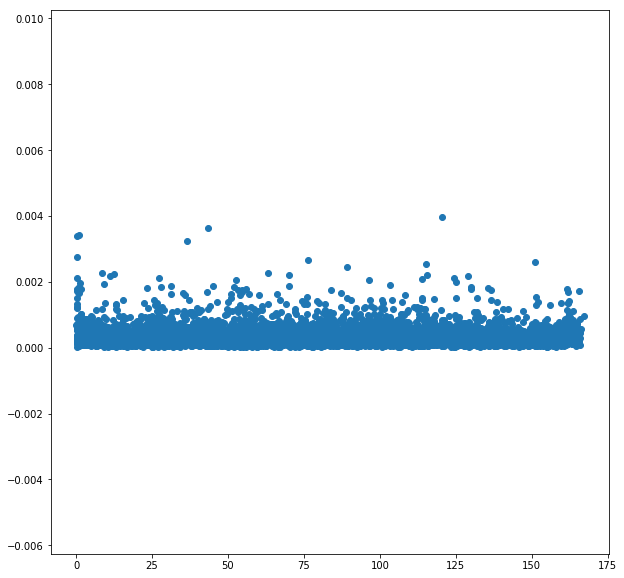

In [17]:
refined_peaks = reindex(indexed_peaks, refiner.batches())
plot_dq_vs_frame(refined_peaks)
#plot_dx_vs_frame(refined_peaks)

In [626]:
fit_data = []
standard_fit_data = []

for peak in refined_peaks:
    try:
        shape = peak.qShape()
    except:
        continue
        
    cov = shape.inverseMetric()
    cov = 0.5*(cov + cov.transpose())
    
    if np.isnan(np.linalg.norm(cov)):
        continue
        
    C = np.linalg.cond(cov)    
    if np.isnan(C) or C > 1e4:
        continue
        
    w, u = np.linalg.eig(cov)
    
    if min(w) < 0:
        continue
        
    detector = peak.data().diffractometer().detector()
    center = peak.getShape().center()
    
    frame = center[2,0]
    state = peak.data().interpolatedState(frame)
    
    px = center[0,0]
    py = center[1,0]
    
    p = detector.pixelPosition(px, py).vector()
    p0 = state.samplePosition
    
    r = np.linalg.norm(p-p0)
    dp = p-p0
    
    Jp = -1/r*np.identity(3) + 1/r**3 * dp.dot(dp.transpose())
    
    rot = state.sampleOrientationMatrix()
    ki = state.ki().rowVector()
    qLab = peak.qPredicted().rowVector().dot(rot.transpose())
    kf = qLab + ki
    kf /= np.linalg.norm(kf)
    kf *= np.linalg.norm(ki)
        
    A = kf.transpose().dot(ki) / np.linalg.norm(ki)**2 - np.identity(3)
    
    q = qLab.reshape(3,1)
    #A = -2*q*q.transpose() / np.linalg.norm(q)**2
 
    
    fit_data.append((cov, rot.transpose(), A, Jp, q.reshape(3,1)))

print(len(fit_data))

/usr/lib/python3.6/site-packages/numpy/linalg/linalg.py:1543: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


6845


In [627]:
from scipy.optimize import least_squares

def KL_divergence(S0, S1):
    k, _ = S0.shape    
    A = np.linalg.inv(S1).dot(S0)    
    return 0.5 * (A.trace() - k - np.log(np.linalg.det(A)))

def encode(Mos, Scatter):
    return np.concatenate([Mos.reshape(9), Scatter.reshape(36)])

def decode(x):
    Mos = x[:9].reshape(3,3)
    Scatter = x[9:].reshape(6,6)
    return Mos, Scatter


def fit_model(Mos, Scatter, R, A, Jp, q):  
    B = np.zeros((3, 6), dtype=np.float)
    B[:3, :3] = R.dot(Jp).dot(R.transpose())
    B[:3, 3:] = R.dot(A) 
    return Mos[0,0]*(np.linalg.norm(q)**2*np.identity(3) - q.dot(q.transpose())) + B.dot(Scatter).dot(B.transpose())

def residual(x):
    Mos, Scat = decode(x)
    res = []
    
    for S, R, A, J, q in fit_data:
        Sfit = fit_model(Mos, Scat, R, A, J, q)
        #diff = np.linalg.inv(S)-np.linalg.inv(Sfit)
        diff = S-Sfit
        res.extend(diff.flatten())
        #res.append(KL_divergence(S, Sfit))
        
    return res

if not True:
    Mos = np.zeros((3,3), dtype=np.float)
    Scatter = np.zeros((6,6), dtype=np.float)

x0 = encode(Mos, Scatter)
res = residual(x0)
print(len(res))

result = least_squares(residual, x0, gtol=3e-16)
Mos, Scatter = decode(result.x)

print(result)


61605
 active_mask: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
        cost: 2.3331358334639964e-08
         fun: array([-2.68156001e-06,  1.32402398e-06, -2.63055821e-08, ...,
        1.94000051e-08, -4.45809644e-07, -9.52990729e-07])
        grad: array([-5.34242473e-17,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -7.17681477e-15,  7.10084830e-15,  1.50552568e-15,
       -5.44788838e-16,  1.86373226e-15,  4.21215826e-16,  4.52449933e-15,
        4.76232829e-15,  4.64889205e-15,  1.00442185e-15,  1.78821996e-16,
        9.71261446e-16,  6.29374194e-15,  3.24959616e-15, -3.61611647e-14,
        2.08681904e-15,  9.27424844e-17, -7.45554165e-15, -9.53020602e-16,
        1.88007604e-15,  6.76045009e-16,  1.18184871e-17,  3.54634

In [479]:
np.abs((x_cov-x_inv_cov))

array([1.97369298e-05, 3.61060708e-05, 2.39950923e-05, 2.25658947e-05,
       1.30751227e-05, 1.13722121e-05, 1.15864421e-05, 7.89836351e-06,
       1.38317172e-06, 8.22520276e-06, 5.34320045e-08, 3.98371902e-08,
       5.34319769e-08, 8.05253867e-06, 1.23114302e-07, 3.98371902e-08,
       1.23114302e-07, 4.73252110e-05, 8.55987425e-06, 2.12101116e-08,
       6.81935852e-06, 2.12101118e-08, 8.43197697e-09, 1.15625352e-07,
       6.81935846e-06, 1.15625352e-07, 5.06467592e-05, 9.44016746e-11,
       4.92451011e-10, 5.84754101e-10, 4.92451011e-10, 1.43391643e-09,
       2.76811618e-10, 5.84754101e-10, 2.76811618e-10, 1.41286247e-10])

In [502]:
M

array([[-1.27635619e-07,  1.19073380e-07, -3.42790116e-08],
       [ 1.19073380e-07, -9.76876806e-08, -2.32364758e-09],
       [-3.42790116e-08, -2.32364758e-09, -2.90157927e-05]])

Mosaicity


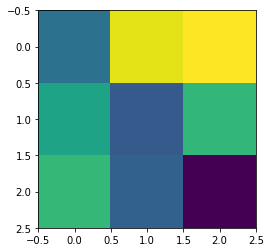

[-2.42600452e-06 -4.01529301e-05 -2.59884246e-05]
Shape


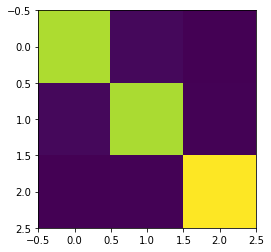

[2.45886986e-07 2.63032517e-07 2.91509121e-07]
Beam


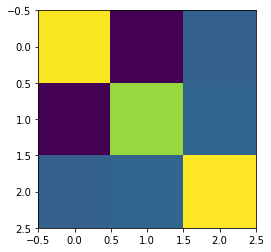

[1.03418967e-06 3.43317645e-06 2.53208679e-06]
Shape-Beam crossterm


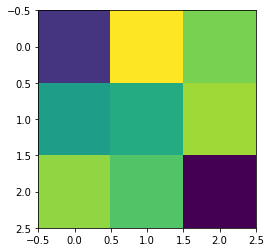

0.10093909893049913


In [628]:
print("Mosaicity")
plt.imshow(Mos)
plt.show()
print(np.linalg.eig(Mos)[0])

print("Shape")
Shape = Scatter[:3, :3]
plt.imshow(Shape)
plt.show()
print(np.linalg.eig(Shape)[0])

print("Beam")
Beam = Scatter[3:, 3:]
plt.imshow(Beam)
plt.show()
print(np.linalg.eig(Beam)[0])

print("Shape-Beam crossterm")
Cross = Scatter[:3, 3:]
plt.imshow(Cross)
plt.show()
print(np.linalg.norm(Cross)**2 / np.linalg.norm(Beam) / np.linalg.norm(Shape))

In [151]:
det = refined_peaks[100].data().diffractometer().detector()

J = det.jacobian(500, 500)

J

array([[-0.00015476,  0.        ,  0.        ],
       [ 0.00047713,  0.        ,  0.        ],
       [ 0.        ,  0.00050056,  0.        ]])

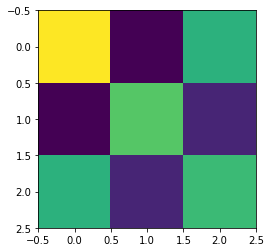

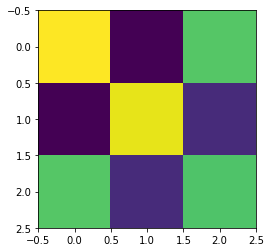

[2.80370319e-07 1.74132390e-06 2.96054464e-06]
[2.61695136e-07 2.71216393e-06 4.32401817e-06]
0.9840506733936337


In [636]:
S, R, A, J, q = random.sample(fit_data, 1)[0]

plt.imshow(np.linalg.inv(S))
plt.show()

Sfit = fit_model(Mos, Scatter, R, A, J, q)

plt.imshow(np.linalg.inv(Sfit))
plt.show()

w_obs, u_obs = np.linalg.eig(S)
w_fit, u_fit = np.linalg.eig(Sfit)

print(w_obs)
print(w_fit)


print(S.transpose().dot(Sfit).trace() / np.linalg.norm(S) / np.linalg.norm(Sfit))

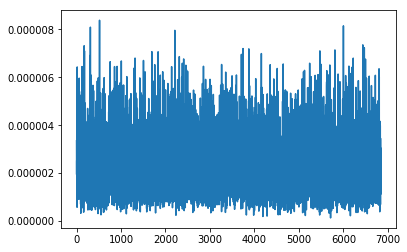

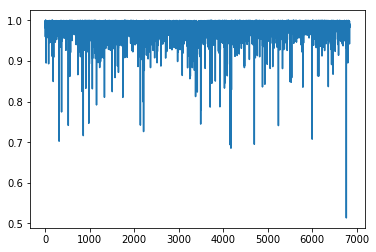

number of good peaks: 6845
mean pearson: 0.984523636876398


In [637]:
errors = []
pearson = []

good_fit_data = fit_data


for S, R, A, J, q in good_fit_data:
    Sfit= fit_model(Mos, Scatter, R, A, J, q)
    errors.append(np.linalg.norm(S-Sfit))
    pearson.append(S.transpose().dot(Sfit).trace() / np.linalg.norm(S) / np.linalg.norm(Sfit))

plt.plot(errors)
plt.show()

plt.plot(pearson)
plt.show()

pearson = np.array(pearson)
pmean = pearson.mean()
pstd = pearson.std()

print("number of good peaks:", len(good_fit_data))
print("mean pearson:", pmean)

new_fit_data = []

for i in range(len(good_fit_data)):
    if pearson[i] < pmean - 10*pstd:
        continue
    new_fit_data.append(good_fit_data[i])
    
good_fit_data = new_fit_data

x0 = encode(Mos, Scatter)
result = least_squares(residual, x0)
Mos, Scatter = decode(result.x)


In [638]:
Mos[0,0]

-1.210451482266772e-05

In [ ]:
errors = []
mean = np.zeros((3,3), dtype=np.float)

good_fit_data = fit_data

for S, R, A in fit_data:
    mean += S
    
mean /= len(fit_data)

for S, R, A in fit_data:
    errors.append(np.linalg.norm(S-mean) / np.linalg.norm(S))
    
plt.plot(range(len(errors)), errors)
plt.show()

errors = np.array(errors)
print(errors.mean())
print(errors.std())

new_fit_data = []

for i in range(len(fit_data)):
    if errors[i] > errors.mean() + 3*errors.std():
        print(i, (errors[i]-errors.mean()) / errors.std())
    else:
        good_fit_data.append(fit_data[i])
               


In [ ]:
def mean_DKL(M, D, data):
    DKLs = [ DKL(S, fit_model(M, D, R, A)) for S, R, A in data]
    return np.array(DKLs).mean()

def DKL(S1, S2):
    d = 0    
    d = np.log(np.linalg.det(S2) / np.linalg.det(S1))
    d += np.linalg.inv(S2).dot(S1).trace()
    d -= S1.shape[0]
    d *= 0.5    
    return d    

In [ ]:
M, D = simplified_soln(good_fit_data)

print("mean DKL: ", mean_DKL(mean, 0*mean, good_fit_data))
print("mean DKL: ", mean_DKL(M, D, good_fit_data))

import random

eps = 0.01

print(mean_error(mean, 0*mean, good_fit_data))

for i in range(10000):
    batch = random.sample(good_fit_data, 100)
    
    if i%500 == 0:
        error = mean_error(M, D, good_fit_data)
        new_error = np.linalg.norm(error)
        print(i, new_error)        
    M, D = fit_step(M, D, batch, eps)

print(M)
print(mean)

errors = []
pearson = []
costheta = []
DKLs = []

for S, R, A in good_fit_data:
    S_fit = fit_model(M, D, R, A)
    #S_fit = fit_model(mean, 0*D, R, A)
    errors.append( np.linalg.norm(S-S_fit) / np.linalg.norm(S_fit))
    
    S1 = S.flatten()
    S2 = S_fit.flatten()
    
    c = S1.dot(S2) / np.linalg.norm(S1) / np.linalg.norm(S2)
    
    cov = np.cov(S1, S2)
    pearson.append(cov[0,1] / np.sqrt(cov[0,0]*cov[1,1]))
    costheta.append(c)
    DKLs.append(DKL(S, S_fit))
    
errors = np.array(errors)
plt.plot(errors)
plt.show()

pearson = np.array(pearson)

print(errors.std())

new_fit_data = []

for i in range(len(good_fit_data)):
    if (pearson[i]-pearson.mean() < -3.0*pearson.std()):
        continue
    else:
        new_fit_data.append(good_fit_data[i])
        
good_fit_data = new_fit_data
print(len(good_fit_data))

print(sum(errors) / len(errors))

plt.plot(pearson)
plt.show()
print("mean peason coefficient: ", pearson.mean())

plt.plot(costheta)
plt.show()

print("mean cos(theta)", np.array(costheta).mean())

plt.plot(DKLs)
plt.show()

print("mean DKL after fit:", np.array(DKLs).mean())

In [ ]:
print(M)
w, u = np.linalg.eig(M)
print(w)
plt.imshow(M)
plt.show()


print(D)
w, u = np.linalg.eig(D)
print(w)
plt.imshow(D)
plt.show()


In [ ]:
peak = refined_peaks[100]

state = peak.data().interpolatedState(peak.getShape().center()[2,0])
R = state.sampleOrientation().transpose()
ki = state.ki().rowVector()
qLab = peak.q().rowVector().dot(R)
kf = qLab + ki
kf /= np.linalg.norm(kf)
kf *= np.linalg.norm(ki)
A = kf.transpose().dot(ki) / np.linalg.norm(ki)**2 - np.identity(3)

shape = nsx.Ellipsoid(peak.getShape())
shape.scale(2.0)

q0 = peak.q().rowVector()


bb = shape.aabb()
lb = bb.lower()
ub = bb.upper()

x0 = int(lb[0,0])
y0 = int(lb[1,0])
z0 = int(lb[2,0])

x1 = int(ub[0,0])
y1 = int(ub[1,0])
z1 = int(ub[2,0])

mux = shape.center()[0,0]
muy = shape.center()[1,0]
muz = shape.center()[2,0]

xs = []
xy = []
zs = []
qs = []
Is = []
Ps = []
Qs = []


N = 0
A = shape.metric()

for z in range(z0, z1):
    image = data.frame(z)
    
    for x in range(x0, x1):
        for y in range(y0, y1):
            xs.append(x)
            ys.append(y)
            zs.append(z)
            Is.append(image[y,x])
            
            A = shape.metric()
            
            u = np.array([[x-mux, y-muy, z-muz]]).transpose()          
            p = np.exp(-u.transpose().dot(A).dot(u).trace() / 2.0)
            Ps.append(p)
            
            
            
            state = peak.data().interpolatedState(z)
            
            pos = peak.data().diffractometer().detector().pixelPosition(x, y)
            
            q = state.sampleQ(pos).rowVector()          
            qs.append(q)
            
            #A = np.linalg.inv(fit_model(M, D, R, A))
            A = peak.qShape().inverseMetric()
            u = (q - q0).transpose()
            Qs.append(np.exp(-u.transpose().dot(A).dot(u).trace() / 2.0))
            
            N += 1
            
Is = np.array(Is)
Ps = np.array(Ps)
Qs = np.array(Qs)

u = Is - Is.mean()
v = Ps - Ps.mean()

print(u.dot(v) / np.linalg.norm(u) / np.linalg.norm(v))

u = Is - Is.mean()
v = Qs - Qs.mean()

print(u.dot(v) / np.linalg.norm(u) / np.linalg.norm(v))

In [ ]:
print("sample position")
plt.plot([state.samplePosition[0] for state in states])
plt.plot([state.samplePosition[1] for state in states])
plt.plot([state.samplePosition[2] for state in states])
plt.show()
    
print("sample orientation perturbation")
plt.plot([state.sampleOrientationOffset[0] for state in states])
plt.plot([state.sampleOrientationOffset[1] for state in states])
plt.plot([state.sampleOrientationOffset[2] for state in states])
plt.show()
    
print("nx, nz")
plt.plot([state.ni[0,0] for state in states])
#plt.plot([state.ni[0,1] for state in states])
plt.plot([state.ni[0,2] for state in states])
plt.show()

In [ ]:
len(refined_peaks)
compute_statistics(refined_peaks, nsx.SpaceGroup("P 21 21 21"), True)

In [ ]:
#predicted = predict_peaks(data, refined_peaks)
#predicted.size()

In [ ]:
data.integratePeaks(refined_peaks, 3.5, 6.0, nsx.ProgressHandler())
compute_statistics(refined_peaks, nsx.SpaceGroup("P 21 21 21"), True)

In [ ]:
def predict_peaks(reference_peaks, data, dmin, dmax, B, batches):    
    pred = nsx.PeakPredictor(data)
    qshape = pred.averageQShape(reference_peaks)
    wavelength = data.diffractometer().source().getSelectedMonochromator().getWavelength()    
    hkls = uc.generateReflectionsInShell(dmin, dmax, wavelength)       
    prediction = pred.predictPeaks(hkls, B)
    
    good_pred = []
    
    for batch in batches:
        bcell = batch.cell()
        preds = pred.predictPeaks(hkls, bcell.reciprocalBasis())
        
        for p in preds:
            if not batch.contains(p.getShape().center()[2,0]):
                continue
                
            hkl = nsx.MillerIndex(p.q(), bcell)
            
            if not hkl.indexed(0.2):
                continue
                
            hkl = hkl.rowVector()
                
            q = hkl.dot(bcell.reciprocalBasis())
            shape = nsx.Ellipsoid(q.transpose(), qshape)
            try:
                shape = pred.toDetectorSpace(shape)
            except:
                continue
                
            p.setShape(shape)                
            p.addUnitCell(bcell, True)
            good_pred.append(p)
    
    return good_pred
    
predicted = predict_peaks(refined_peaks, data, 1.5, 50.0, uc.reciprocalBasis(), refiner.batches())

In [ ]:
data.integratePeaks(predicted, 3.5, 6.0, nsx.ProgressHandler())
compute_statistics(predicted, nsx.SpaceGroup("P 21 21 21"), True)

In [ ]:
high_q = []

for p in predicted:
    q = np.linalg.norm(p.getQ().rowVector())
    d = 1 / q
    if d < 1.5 or d > 1.8:
        continue
        
    high_q.append(p)
    
print(len(high_q))
data.integratePeaks(high_q, 3.0, 5.0, nsx.ProgressHandler())
compute_statistics(high_q, nsx.SpaceGroup("P 21 21 21"), True)

In [ ]:
qs = []
slices = []
Is = []
sigmas = []
Isigmas = []
frames = []

for p in predicted:
    inten = p.correctedIntensity()
    isigma = inten.value() / (inten.sigma()+1e-6)
    
    #if (isigma > 1.0):
    #    continue

    frames.append(p.getShape().center()[2,0])
    Is.append(inten.value())
    sigmas.append(inten.sigma())
    Isigmas.append(inten.value() / (inten.sigma()+1e-6))
    qs.append(np.linalg.norm(p.getQ().rowVector()))
    slices.append(p.getIntegrationRegion().bestSlice())
    
plt.scatter(qs, slices)
plt.title("qs, slices")
plt.show()

plt.scatter(slices, Is)
plt.title("slices, Is")
plt.show()

plt.scatter(slices, sigmas)
plt.title("slices, sigmas")
plt.show()

plt.scatter(slices, Isigmas)
plt.title("slices, Isigmas")
plt.show()

plt.scatter(slices, frames)
plt.title("slices, frames")
plt.show()

plt.scatter(qs, Isigmas)
plt.title("qs, Isigmas")
plt.show()

In [ ]:
Isigmas

In [ ]:
compute_statistics(predicted, nsx.SpaceGroup("P 21 21 21"), True)


In [ ]:
strong_peaks = []

for p in predicted:
    inten = p.correctedIntensity()
    I = inten.value()
    sigma = inten.sigma()
    
    if sigma < 0.1:
        continue
        
    #if I / sigma < 0.5:
    #    continue
        
    strong_peaks.append(p)
    
print(len(strong_peaks))
compute_statistics(strong_peaks, nsx.SpaceGroup("P 21 21 21"), True)

In [ ]:
p = high_q[100]
region = p.getIntegrationRegion()
intgr = p.getIntegration()

shell_inten = intgr.shellIntensity()
shell_point = intgr.shellPoints()

In [ ]:
bad = None

for p in high_q:
    inten = p.correctedIntensity()
    
    sigma = inten.sigma()
    I = inten.value()
    
    if sigma > 0.0 and I/sigma < -5.:
        bad = p
        break

In [ ]:
shell = p.getIntegration()

plt.plot(shell.shellIntensity() / shell.shellPoints())
plt.show()

plt.plot(shell.shellPoints())
plt.show()

print(p.getIntegrationRegion().bestSlice())

In [ ]:
bb = p.getShape().aabb()
upper = bb.upper()
lower = bb.lower()

xmin = int(lower[0,0])
xmax = int(upper[0,0])
ymin = int(lower[1,0])
ymax = int(upper[1,0])
zmin = int(lower[2,0])
zmax = int(upper[2,0])

print(lower.transpose())
print(upper.transpose())

z = 0.5*(zmin+zmax)

expand=10

images = []

for i in range(-3, 3):
    image = data.frame(round(z)+i)
    image = image[ymin-expand:ymax+expand+1, xmin-expand:xmax+expand+1]
    plt.imshow(image, vmin=350, vmax=600)
    plt.show()
    print(image.mean())
    images.append(image)


In [ ]:
x = np.linspace(-3, 3, num=20)
x, y = np.meshgrid(x, x)
kernel = np.exp(-(x**2+y**2)/2.5)
kernel /= kernel.sum()
plt.imshow(kernel)
plt.show()

from scipy.signal import convolve2d

for image in images:
    conv = convolve2d(image, kernel, mode='same', boundary='wrap')
    plt.imshow(conv, vmin=350, vmax=700)
    plt.show()

In [ ]:
image.max()
image.min()

In [ ]:
def peak_volume(p):
    M = p.getShape().metric()
    return np.pi * 4 / 3.0 / np.sqrt(np.linalg.det(M))

In [ ]:
nshells = 20
dmin = 1.5
dmax = 50.0

shells = nsx.ResolutionShell(dmin, dmax, nshells)
stats = []

included = 0

for peak in predicted:
    inten = peak.correctedIntensity()
    I = inten.value()
    sigma = inten.sigma()
        
    if (sigma < 10.0):
        continue
        
    best_slice = peak.getIntegrationRegion().bestSlice()
        
    if best_slice < 4 or best_slice > 15:
        continue
        
    shells.addPeak(peak)
    included += 1
       
for i in range(nshells):
    shell = shells.shell(i)
    stats.append(compute_statistics(shell, nsx.SpaceGroup("P 21 21 21"), True))
       
def print_stats():    
    print(" n      dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue")
    d = shells.getD()

    for i,s in enumerate(stats):
        
        fmt = "{0:4d} {1:8.3f} {2:8.3f} {3:8.3f} {4:8.3f} {5:8.3f} {6:8.3f} {7:8.3f}"
        print(fmt.format(len(shells.shell(i)), d[i], d[i+1], s["Rmeas"], s["Rmerge"], s["Rpim"], s["CChalf"], s["CCtrue"]))
    
print_stats()

print("Total peaks", included)

In [ ]:
merged_data = nsx.MergedData(nsx.SpaceGroup("P 21 21 21"), True)
bad = None

for peak in predicted:
    if not peak.isSelected():
        continue
    
    inten = peak.correctedIntensity()
    if inten.sigma() < 1.0:
        continue
    
    merged_data.addPeak(peak)
    
ds = []
chis = []
        
for merged_peak in merged_data.getPeaks():
    chi2 = merged_peak.chi2()
    
    d = 1.0 / np.linalg.norm(merged_peak.getPeaks()[0].getQ().rowVector())
    
    if d > 2.0:
        continue
    
    ds.append(d)
    chis.append(chi2)
    
    if chi2 > 200:
        bad = merged_peak
    
plt.scatter(ds, chis)
plt.show()

In [ ]:
bad

In [ ]:
def show_peak(p):
    bb = p.getShape().aabb()
    upper = bb.upper()
    lower = bb.lower()

    xmin = int(lower[0,0])
    xmax = int(upper[0,0])
    ymin = int(lower[1,0])
    ymax = int(upper[1,0])
    zmin = int(lower[2,0])
    zmax = int(upper[2,0])

    z = round(0.5*(zmin+zmax))

    expand=5
    
    print(lower.transpose(), upper.transpose())

    image = data.frame(z)
    image = image[ymin-expand:ymax+expand+1, xmin-expand:xmax+expand+1]
    plt.imshow(image)
    plt.show()


In [ ]:
bad_peaks = [ p for p in bad.getPeaks() ]

for p in bad_peaks:
    inten = p.correctedIntensity()    
    d = 1.0 / np.linalg.norm(p.getQ().rowVector())
    print(inten.value(), inten.sigma(), d)
    show_peak(p)

In [ ]:
def distortion(p):
    A = np.linalg.inv(p.getShape().metric())
    return  np.power(np.linalg.det(A), 2/3.0) / ((A**2).trace() / 3)

In [ ]:
qs = []
ds = []
vs = []
rs = []
dists = []
lors = []

for p in predicted:
    if (p.getRawIntensity().sigma() < 1.0):
        continue
    
    v = peak_volume(p)
    vs.append(v)
    rs.append(np.power(v, 1/3.))
    q = np.linalg.norm(p.getQ().rowVector())
    qs.append(q)
    ds.append(1/q)
    dists.append(distortion(p))
    
    raw_inten = p.getRawIntensity().value()
    cor_inten = p.getCorrectedIntensity().value()
    lors.append(cor_inten/(raw_inten+1e-10))
    
plt.figure(figsize=(10,10))
plt.scatter(qs, dists, s=5.0)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(qs, vs, s=1.0)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(qs, lors, s=5.0)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(dists, lors, s=5.0)
plt.show()

#plt.figure(figsize=(10,10))
#plt.scatter(ds, rs, s=1.0)
#plt.show()

#plt.figure(figsize=(10,10))
#plt.scatter(qs, rs, s=1.0)
#plt.show()


In [ ]:
small_ds = []
small_lor = []

for i in range(len(ds)):
    if ds[i] > 2.0:
        continue
        
    small_ds.append(ds[i])
    small_lor.append(lors[i])
    
plt.scatter(small_ds, small_lor)
plt.show()

In [ ]:
print(np.min(lors))
print(np.max(lors))

In [ ]:
qs = []
xs = []
ys = []
zs = []


pred_qs = []
pred_xs = []
pred_ys = []
pred_zs = []

pred_lor = []

for p in refined_peaks:
    
    bb = p.getShape().aabb()
    dx = bb.upper() - bb.lower()
    
    if (np.linalg.norm(dx) > 50):
        continue
    
    xs.append(dx[0,0])
    ys.append(dx[1,0])
    zs.append(dx[2,0])
    qs.append(np.linalg.norm(p.getQ().rowVector()))
    

for p in predicted:
    
    bb = p.getShape().aabb()
    dx = bb.upper() - bb.lower()
    
    if (np.linalg.norm(dx) > 50):
        continue
    
    pred_xs.append(dx[0,0])
    pred_ys.append(dx[1,0])
    pred_zs.append(dx[2,0])
    pred_qs.append(np.linalg.norm(p.getQ().rowVector()))
    
    if p.getRawIntensity().value() != 0:
        pred_lor.append(p.correctedIntensity().value() / p.getRawIntensity().value())
    else:
        pred_lor.append(0.0)

    #eps = 1e-2
   # if (dx[1,0] < 5+eps and dx[1,0]>5-eps):
      #  print(dx)

scale = 0.5

plt.figure(figsize=(10,10))
plt.scatter(pred_qs, pred_xs, s=scale)
plt.scatter(qs, xs, s=scale)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(pred_qs, pred_ys, s=scale)
plt.scatter(qs, ys, s=scale)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(pred_qs, pred_zs, s=scale)
plt.scatter(qs, zs, s=scale)
plt.show()


plt.figure(figsize=(10,10))
plt.scatter(1.0 / np.array(pred_qs), pred_lor, s=scale)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(1.0 / np.array(pred_zs), pred_lor, s=scale)
plt.show()



In [ ]:
nshells = 20
dmin = 1.5
dmax = 50.0

shells = nsx.ResolutionShell(dmin, dmax, nshells)
stats = []

num_good = 0

for peak in predicted:
    
    inten = peak.correctedIntensity()
    
    if (inten.sigma() <= 0):
        continue
        
    #if (inten.value() / inten.sigma() < 0.1):
    #    continue
                
    bb = peak.getShape().aabb()
    dx = bb.upper()-bb.lower()
    
    dx = np.linalg.norm(dx)    
    if dx > 2000:
        continue
        
    # detector plates
    c = peak.getShape().center()
    
    if c[0,0] > 1720 and c[0,0] < 1750:
        continue
    
    shells.addPeak(peak)
    num_good += 1
    
for i in range(nshells):
    shell = shells.shell(i)
    stats.append(compute_statistics(shell, nsx.SpaceGroup("P 21 21 21"), True))
   
def print_stats():    
    print("   dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue")
    d = shells.getD()

    for i,s in enumerate(stats):
        
        fmt = "{0:8.3f} {1:8.3f} {2:8.3f} {3:8.3f} {4:8.3f} {5:8.3f} {6:8.3f}"
        print(fmt.format(d[i], d[i+1], s["Rmeas"], s["Rmerge"], s["Rpim"], s["CChalf"], s["CCtrue"]))
    
print_stats()
print(num_good)

In [ ]:
qs = []
dxs = []

for peak in predicted:
    
    
   

                
    bb = peak.getShape().aabb()
    dx = bb.upper()-bb.lower()
    
    dx = np.linalg.norm(dx) 
    
    if dx > 1500:
        continue
    
    qs.append(np.linalg.norm(peak.getQ().rowVector()))
    dxs.append(dx)
    
plt.scatter(qs, dxs)
plt.show()

In [ ]:
really_bad = []

for peak in predicted:
    inten = peak.correctedIntensity()
    
    if (inten.sigma() <= 0.0):
        continue
        
    Isigma = inten.value() / inten.sigma()
    
    if inten.sigma() < 30.0:
        #bb = peak.getShape().aabb()
        #print(bb.upper().transpose(), bb.lower().transpose())
        #print(inten.value(), inten.sigma())
       # print(1.0 / np.linalg.norm(peak.getQ().rowVector()))
        #print("--------------------------------")
        
        really_bad.append(peak)
        
print(len(really_bad))

In [ ]:
qs = []
xs = []
ys = []
zs = []
Is = []
sigmas = []

for peak in really_bad:

    qs.append(np.linalg.norm(peak.q().rowVector()))
    
    bb = peak.getShape().aabb()
    c = peak.getShape().center()
    
    xs.append(c[0,0])
    ys.append(c[1,0])
    zs.append(c[2,0])
    
    inten = peak.correctedIntensity()
    sigmas.append(inten.sigma())    
    Is.append(inten.value())
    

    
plt.figure(figsize=(10,10))
plt.scatter(xs, Is)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(ys, Is)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(zs, Is)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(xs, ys)
plt.show()


In [ ]:
xs

In [ ]:
qs = []
Isigmas = []

for p in predicted:
    
    
    inten = p.correctedIntensity()
    
    if inten.sigma() <= 0:
        continue
        
    
    Isigma = inten.value() / inten.sigma()
    
    if Isigma > 3.0:
        continue
    
    qs.append(np.linalg.norm(p.q().rowVector()))
    Isigmas.append(Isigma)
    
    
plt.scatter(qs, Isigmas)
plt.show()

In [ ]:
import random

bad_peaks = []

for p in predicted:
    inten = p.correctedIntensity()
    
    if inten.sigma() <= 0:
        continue
        
    Isigma = inten.value() / inten.sigma()
    
    if Isigma > 0 or Isigma < -1.5:
        continue
    
    bad_peaks.append(p)

In [ ]:
bad = random.sample(bad_peaks, 1)[0]
inten = bad.correctedIntensity()
print(inten.value(), inten.value()/inten.sigma())

In [ ]:
c = bad.getShape().center().reshape(3)
bb = bad.getShape().aabb()

ub = bb.upper().reshape(3)
lb = bb.lower().reshape(3)

print(c.transpose())
print(bb.upper().transpose(), bb.lower().transpose())

ub = ub.reshape(3)
lb = lb.reshape(3)

dx = 0.5*(ub-c)
print(dx)

lb = [ int(round(-6*dx[i]+c[i])-1) for i in range(3) ]
ub = [ int(round(6*dx[i]+c[i])+1) for i in range(3) ]

print(lb, ub)

integral = bad.getIntegration()
region = bad.getIntegrationRegion()

avg = integral.shellIntensity() / integral.shellPoints()

plt.plot(avg)
plt.show()

frames = []

for z in range(lb[2], ub[2]+1):
    image = data.frame(z)[lb[1]:ub[1]+1, lb[0]:ub[0]+1]
    frames.append(image)
    plt.imshow(image)
    plt.show()

In [ ]:
from scipy.signal import convolve2d

width = 11
height = 11

x = np.linspace(0, width, num=width) - width/2
y = np.linspace(0, height, num=height) - height/2
x, y = np.meshgrid(x, y)

kernel = np.exp(-0.5*(x**2+y**2)/6)
kernel /= kernel.sum()

plt.imshow(kernel)
plt.show()

kernel = np.roll(kernel, round(width/2), axis=0)
kernel = np.roll(kernel, round(height/2), axis=1)

for frame in frames:
    conv = convolve2d(frame, kernel, mode='same', boundary='wrap')
    plt.imshow(conv)
    plt.show()

In [ ]:
plt.plot(integral.shellPoints())
plt.show()

plt.plot(integral.shellIntensity())
plt.show()

In [ ]:
pred = nsx.PeakPredictor(data)
qshape = pred.averageQShape(predicted)

In [ ]:
np.linalg.eig(qshape)